Library


In [149]:
import numpy as np
import math
import pickle
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

# Dataset Inference


## Load


Raw


In [150]:
with open(r"C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdasan-Artificial_Tugas-Besar\Dataset\dataset_labelled.pkl", "rb") as f:
    dataset = pickle.load(f)

In [151]:
len(dataset)

793

Normalisasi, Split, dan Batching


In [152]:
X = [[data[3], data[4]] for data in dataset]
original_labels = [int(data[2]) for data in dataset]
y = [1 if label in (0, 1) else 2 for label in original_labels]

## Analisa Statistik


In [153]:
t1 = 0
t2 = 0
for i in y:
    if i == 1:
        t1 += 1
    else:
        t2 += 1

print(t1, t2)

547 246


Describe


In [154]:
df_raw = pd.DataFrame(X, columns=['rms', 'zcr'])
df_raw['label'] = y

In [155]:
for label in df_raw['label'].unique():
    print(f"Label: {label}")
    display(df_raw[df_raw['label'] == label].describe().T)

Label: 1


,count,mean,std,min,25%,50%,75%,max
rms,547.0,0.067685,0.081579,0.0,0.010218,0.04075,0.090788,0.448288
zcr,547.0,5458.301645,4194.242814,0.0,1403.000000,5247.00000,9229.000000,14626.000000
label,547.0,1.000000,0.000000,1.0,1.000000,1.00000,1.000000,1.000000


Label: 2


,count,mean,std,min,25%,50%,75%,max
rms,246.0,0.022774,0.021007,0.0,0.00587,0.021626,0.033709,0.091311
zcr,246.0,8453.943089,3326.650988,0.0,5966.75000,8722.500000,10897.250000,14691.000000
label,246.0,2.000000,0.000000,2.0,2.00000,2.000000,2.000000,2.000000


Visualization


<Axes: title={'center': 'rms'}, xlabel='label'>

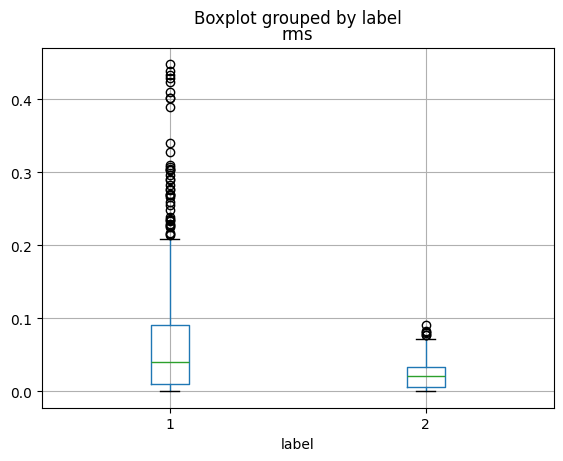

In [156]:
df_raw.boxplot(column=['rms'], by='label')

<Axes: title={'center': 'zcr'}, xlabel='label'>

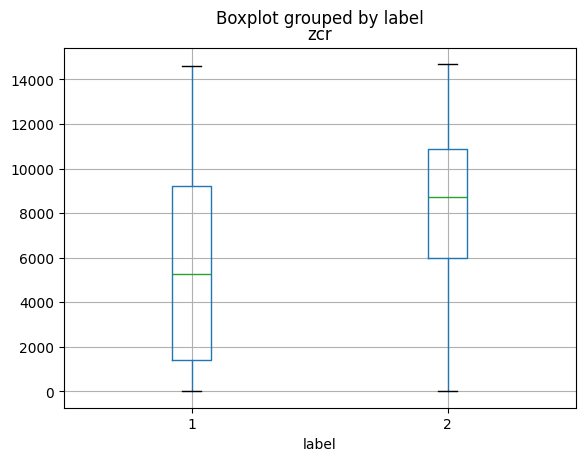

In [157]:
# Visualize persebaran data dengan boxplot
df_raw.boxplot(column=['zcr'], by='label')

Hyperparameters


In [158]:
RMS_LOW_C = 0.0168545
RMS_LOW_S = 296.65667922513273

RMS_MEDIUM_M = 0.048329
RMS_MEDIUM_S = 0.036058598726114645

RMS_HIGH_C = 0.229253
RMS_HIGH_S = 22.827402013376858


ZCR_INFREQ_C = 4614.5
ZCR_INFREQ_S = 0.0010835410120273053

ZCR_MODERATE_M = 6150.125
ZCR_MODERATE_S = 4031.5286624203823

ZCR_FREQ_C = 10328.875
ZCR_FREQ_S = 0.0011462303349858154


LOUD_C = 0.8
LOUD_S = 25.0

NOT_LOUD_C = 0.2
NOT_LOUD_S = 25.0

# Fuzzy Class and Functions


Membership Functions


In [159]:
def sigmf(x, c, s):
    return 1 / (1 + math.exp(-s * (x - c)))

def gaussmf(x, m, s):
    return math.exp(-((x - m) ** 2) / (2 * s ** 2))

Fuzzy Sets


In [160]:
def fuzzify_rms(val):
    return {
        'low': sigmf(val, RMS_LOW_C, RMS_LOW_S),
        'medium': gaussmf(val, RMS_MEDIUM_M, RMS_MEDIUM_S),
        'high': sigmf(val, RMS_HIGH_C, RMS_HIGH_S)
    }

def fuzzify_zcr(val):
    return {
        'infrequent': sigmf(val, ZCR_INFREQ_C, ZCR_INFREQ_S),
        'moderate': gaussmf(val, ZCR_MODERATE_M, ZCR_MODERATE_S),
        'frequent': sigmf(val, ZCR_FREQ_C, ZCR_FREQ_S)
    }

## Fuzzy Inference System


### Mamdani Inference Engine


In [161]:
def mamdani_rule_evaluation(rms_set, zcr_set):
    return [
        ('not_loud', min(rms_set['low'], zcr_set['infrequent'])),
        ('not_loud', min(rms_set['low'], zcr_set['moderate'])),
        ('not_loud', min(rms_set['low'], zcr_set['frequent'])),
        ('not_loud', min(rms_set['medium'], zcr_set['infrequent'])),
        ('not_loud', min(rms_set['medium'], zcr_set['moderate'])),
        ('loud', min(rms_set['medium'], zcr_set['frequent'])),
        ('loud', min(rms_set['high'], zcr_set['infrequent'])),
        ('loud', min(rms_set['high'], zcr_set['moderate'])),
        ('loud', min(rms_set['high'], zcr_set['frequent']))
    ]

def mamdani_aggregate(rules):
    loud_dom = [s for l, s in rules if l == 'loud']
    not_loud_dom = [s for l, s in rules if l == 'not_loud']
    return max(loud_dom) if loud_dom else 0, max(not_loud_dom) if not_loud_dom else 0

def mamdani_defuzzify(loud, not_loud):
    output_range = np.linspace(0, 1, 101)
    numerator = 0
    denominator = 0
    for o in output_range:
        mu = max(
            min(sigmf(o, LOUD_C, LOUD_S), loud),
            min(sigmf(o, NOT_LOUD_C, NOT_LOUD_S), not_loud)
        )
        numerator += o * mu
        denominator += mu
    return numerator / denominator if denominator != 0 else 0

def fuzzy_mamdani_infer(rms_val, zcr_val):
    rms_set = fuzzify_rms(rms_val)
    zcr_set = fuzzify_zcr(zcr_val)
    rules = mamdani_rule_evaluation(rms_set, zcr_set)
    loud, not_loud = mamdani_aggregate(rules)
    return mamdani_defuzzify(loud, not_loud)

### Sugeno Inference Engine


In [162]:
def sugeno_rule_evaluation(rms_set, zcr_set):
    return [
        (min(rms_set['low'], zcr_set['infrequent']), 0.0),
        (min(rms_set['low'], zcr_set['moderate']), 0.0),
        (min(rms_set['low'], zcr_set['frequent']), 0.0),
        (min(rms_set['medium'], zcr_set['infrequent']), 0.0),
        (min(rms_set['medium'], zcr_set['moderate']), 0.0),
        (min(rms_set['medium'], zcr_set['frequent']), 1.0),
        (min(rms_set['high'], zcr_set['infrequent']), 1.0),
        (min(rms_set['high'], zcr_set['moderate']), 1.0),
        (min(rms_set['high'], zcr_set['frequent']), 1.0)
    ]

def sugeno_weighted_average(rules):
    numerator = sum(w * z for w, z in rules)
    denominator = sum(w for w, _ in rules)
    return numerator / denominator if denominator != 0 else 0

def fuzzy_sugeno_infer(rms_val, zcr_val):
    rms_set = fuzzify_rms(rms_val)
    zcr_set = fuzzify_zcr(zcr_val)
    rules = sugeno_rule_evaluation(rms_set, zcr_set)
    return sugeno_weighted_average(rules)

## Classification


In [163]:
def classify_output(output):
    return 1 if output >= 0.5 else 2

def classify_mamdani(rms_val, zcr_val):
    output = fuzzy_mamdani_infer(rms_val, zcr_val)
    return classify_output(output)

def classify_sugeno(rms_val, zcr_val):
    output = fuzzy_sugeno_infer(rms_val, zcr_val)
    return classify_output(output)

# Example


Label 1 (Suara Keras)


In [164]:
rms_val = 0.07
zcr_val = 9000

print(classify_mamdani(rms_val, zcr_val))
print(classify_sugeno(rms_val, zcr_val))

1
2


Label 2 (Suara Background)


In [165]:
rms_val = 0.7
zcr_val = 9000

print(classify_mamdani(rms_val, zcr_val))
print(classify_sugeno(rms_val, zcr_val))

1
1


# Inference


In [166]:
# Inference
y_mamdani = []
y_sugeno = []

for (rms, zcr) in X:
    y_mamdani.append(classify_mamdani(rms, zcr))
    y_sugeno.append(classify_sugeno(rms, zcr))

# Evaluate
print("Mamdani")
print(f"Accuracy: {accuracy_score(y, y_mamdani)}")
print(f"Precision: {precision_score(y, y_mamdani)}")
print(f"Recall: {recall_score(y, y_mamdani)}")
print(f"F1-Score: {f1_score(y, y_mamdani)}")
print(f"Confusion Matrix:\n {confusion_matrix(y, y_mamdani)}")

print("\nSugeno")
print(f"Accuracy: {accuracy_score(y, y_sugeno)}")
print(f"Precision: {precision_score(y, y_sugeno)}")
print(f"Recall: {recall_score(y, y_sugeno)}")
print(f"F1-Score: {f1_score(y, y_sugeno)}")
print(f"Confusion Matrix:\n {confusion_matrix(y, y_sugeno)}")

Mamdani
Accuracy: 0.6897856242118537
Precision: 0.6897856242118537
Recall: 1.0
F1-Score: 0.8164179104477612
Confusion Matrix:
 [[547   0]
 [246   0]]

Sugeno
Accuracy: 0.32156368221941994
Precision: 1.0
Recall: 0.016453382084095063
F1-Score: 0.03237410071942446
Confusion Matrix:
 [[  9 538]
 [  0 246]]
